# LLM detection
## Practical Data Science course, MSc in Data Science (2023/2024)
###  Assignment #3

---

> Dimitris Tsirmpas <br>
> MSc in Data Science f3352315 <br>
> Athens University of Economics and Business

## Disclaimers

- Most documentation was generated by ChatGPT, and was manually corrected / augmented where necessary.
- In each case where code has been obtained from outside sources, is clearly listed either in comments or in the markdown explaining the code block.

## Data Augmentation

We begin by reviewing the data provided to us by the competition:

In [1]:
from tqdm.notebook import tqdm_notebook
from tqdm.auto import tqdm
from time import time

import pandas as pd
import numpy as np
import os

# file path module
import notebook_config


# enable progress bar functionality
tqdm_notebook().pandas()
start = time()

0it [00:00, ?it/s]

In [2]:
train_df = pd.read_csv(os.path.join(notebook_config.DATA_DIR, "train_essays.csv"))
train_df

,id,prompt_id,text,generated
0,0059830c,0,Cars. Cars have been around since they became ...,0
1,005db917,0,Transportation is a large necessity in most co...,0
2,008f63e3,0,"""America's love affair with it's vehicles seem...",0
3,00940276,0,How often do you ride in a car? Do you drive a...,0
4,00c39458,0,Cars are a wonderful thing. They are perhaps o...,0
...,...,...,...,...
1373,fe6ff9a5,1,There has been a fuss about the Elector Colleg...,0
1374,ff669174,0,Limiting car usage has many advantages. Such a...,0
1375,ffa247e0,0,There's a new trend that has been developing f...,0
1376,ffc237e9,0,As we all know cars are a big part of our soci...,0


Out of these we have been provided with only 3 generated essays:

In [3]:
train_df[train_df.generated == 1]

,id,prompt_id,text,generated
704,82131f68,1,"This essay will analyze, discuss and prove one...",1
740,86fe4f18,1,I strongly believe that the Electoral College ...,1
1262,eafb8a56,0,"Limiting car use causes pollution, increases c...",1


### Prompting

Unless we procure more data the task is impossible. We will thus use prompting to produce our own generated Dataset.

For this task we will use ChatGPT. The prompts were manually given using the official website, and exported the responses in Markdown form using the very convenient [ChatGPT Conv Down](https://addons.mozilla.org/en-US/firefox/addon/chatgpt-convdown/) Firefox addon. 

We used three prompting strategies to procure our generated Dataset:
* The standard prompt (used for the human essays) without sources
* The standard prompt using all the sources, with a role prompt to persuade the model into writing in a more simplistic tone mirroring the tone used in the human essays
* The standard prompt with a role prompt, using a different subset of the sources each time 
* The standard prompt with a role prompt and a different subset of the human essays instead of sources, in order to "mimic" the tone and style of these essays

This procedure was repeated for both types of prompts provided in the dataset (car-free cities and the Electoral College). The conversation context was periodically refreshed in order to avoid the model repeating its own generated essays. Following this procedure we hope to obtain a thorough dataset being as close as possible to the actual operational dataset.

Details on the prompts themselves can be found in `report.pdf`.

### Dataset Caveats

Unfortunately, even following the above strategy does not yield as good results as we would hope for. The biggest issue by far is that ChatGPT's output is formulaic and carries a distinct tone which is most of the time distinct from the students'. 

Role prompting and including human essays as input slightly alleviates the problem but does not eradicate it. Trying to explicitly set the tone of the generated essays leads to a complete collapse in tone, with outputs as *artistic* as the one below:

>Dear [Senator's Name],
>
>Hope this letter finds you chill. I wanted to throw my two cents into the mix about the whole Electoral College debate. It's like a hot topic, right? Some say we should keep it, others are all about switching to the popular vote. Here's where I'm at.
>
>So, keeping the Electoral College – it's got its quirks, but it's not all bad. I get it, voting for electors instead of the actual president seems a bit weird. But, like, it's been working, hasn't it? It's like a system our folks set up ages ago, and yeah, maybe it's not perfect, but it's got a rhythm." [...]


### Importing the datasets

In [4]:
import os


def csv_output(df: pd.DataFrame, filename: str) -> None:
    """
    Save a pandas DataFrame to a CSV file.

    :param df: The DataFrame to be saved.
    :type df: pd.DataFrame

    :param filename: The name of the CSV file.
    :type filename: str

    :return: This function does not return anything.
    :rtype: None
    """
    file = os.path.join(notebook_config.OUTPUT_DIR, filename)
    df.to_csv(file, encoding = 'utf8')
    print(f"File saved successfully as {file}")


def save_plot(filename: str) -> None:
    """
    Saves a plot to the output directory.

    :param filename: The name of the file for the Figure.
    :type filename: str
    """
    path = os.path.join(notebook_config.OUTPUT_DIR, filename)
    plt.savefig(path, bbox_inches="tight")
    print(f"Figured saved to " + path)

In [5]:
def read_gpt(file: str) -> pd.Series:
    """
    Read and extract ChatGPT responses from a file.

    :param file: A string specifying the name of the file to be read.
    :type file: str

    :return: A pandas Series containing ChatGPT responses extracted from the file.
    :rtype: pd.Series
    """
    with open(os.path.join(notebook_config.DATA_DIR, file), encoding="utf8") as f:
        contents = f.read()
    responses = list(filter(lambda x: x.startswith(" ChatGPT"), 
                        contents.split("##")))
    clear_responses = [res.replace("ChatGPT", "").replace("~", "").strip() 
                            for res in responses]
    return pd.Series(clear_responses)


def create_dataset(text_row: pd.Series, prompt_id: int, llm:str, source: str) -> pd.DataFrame:
    """
    Create a dataset DataFrame from a pandas Series of text data.

    :param text_row: A pandas Series containing text data.
    :type text_row: pd.Series
    :param prompt_id: An integer specifying the prompt ID for the dataset.
    :type prompt_id: int
    :param llm: A string specifying the language model used for generating the text.
    :type llm: str
    :param source: A string specifying the source of the text data.
    :type source: str

    :return: A DataFrame containing the created dataset.
    :rtype: pd.DataFrame
    """
    data_text = text_row
    df = pd.DataFrame({"id": [str(hash(text)) for text in data_text],
                     "text": data_text, 
                       "prompt_id": np.full_like(data_text, prompt_id),
                       "generated": np.ones_like(data_text),
                       "llm": llm,
                       "source": source})
    df.prompt_id = df.prompt_id.astype(int)
    df.generated = df.generated.astype(int)
    return df

In [6]:
envir_df = create_dataset(read_gpt("chatgpt_cars.md"), 
                          prompt_id=0, 
                          llm="ChatGPT", 
                          source="Dimitris Tsirmpas")
elect_df = create_dataset(read_gpt("chatgpt_electoral.md"),
                          prompt_id=1, 
                          llm="ChatGPT",
                          source="Dimitris Tsirmpas")

Additionally, we will procure generated essays from two other sources:
* one dataset generated by Konstantina Liagkou for the purposes of the project
* one dataset generated by Muhammad Rizqi, made publically available on his [recent post on LLM detection](https://medium.com/@mrizqi6061/how-i-generate-llm-generated-text-dataset-using-palm-google-generative-ai-in-google-colab-458c7797a5ac).

In [7]:
palm_car = pd.read_csv(os.path.join(notebook_config.DATA_DIR, "cars_generated.csv"))
palm_car_df = create_dataset(palm_car.text, 0, "PaLM",  "Konstantina Liagkou")
palm_car_df

,id,text,prompt_id,generated,llm,source
0,2706070325550928338,Cars have been a major part of our lives for a...,0,1,PaLM,Konstantina Liagkou
1,8304849341424211841,"Limiting car usage has many advantages, such a...",0,1,PaLM,Konstantina Liagkou
2,-1841955124139672827,"""America's love affair with it's vehicles seem...",0,1,PaLM,Konstantina Liagkou
3,1491668036995756067,"Cars are convenient, but they can be harmful t...",0,1,PaLM,Konstantina Liagkou
4,-6715567450662082236,"Cars are a convenient way to get around, but t...",0,1,PaLM,Konstantina Liagkou
...,...,...,...,...,...,...
1370,-3366661706936045973,**Limiting Car Usage**\r\n\r\nCars are a major...,0,1,PaLM,Konstantina Liagkou
1371,-257757399966942854,Limiting car usage has many advantages. For ex...,0,1,PaLM,Konstantina Liagkou
1372,8834934547816523285,Limiting car usage is a great way to improve o...,0,1,PaLM,Konstantina Liagkou
1373,509302526049306517,As we all know cars are a big part of our soci...,0,1,PaLM,Konstantina Liagkou


In [8]:
palm_elect = pd.read_csv(os.path.join(notebook_config.DATA_DIR, "elections_generated.csv"))
palm_elect_df = create_dataset(palm_elect.text, 1, "PaLM",  "Konstantina Liagkou")
palm_elect_df

,id,text,prompt_id,generated,llm,source
0,-4313087706367012839,"Dear Senator,\r\n\r\nI am writing to you today...",1,1,PaLM,Konstantina Liagkou
1,68278590333758670,"Dear Senator,\r\n\r\nI am writing to you today...",1,1,PaLM,Konstantina Liagkou
2,133363997729,NaN,1,1,PaLM,Konstantina Liagkou
3,6333458335293448592,"Dear Senator,\r\n\r\nI am writing to you today...",1,1,PaLM,Konstantina Liagkou
4,-6111941774445621907,"Dear Senator,\r\n\r\nI am writing to you today...",1,1,PaLM,Konstantina Liagkou
...,...,...,...,...,...,...
1370,7263662554673837816,"Dear Senator,\r\n\r\nI am writing to you today...",1,1,PaLM,Konstantina Liagkou
1371,-6385593245447884872,"Dear Senator,\r\n\r\nI am writing to you today...",1,1,PaLM,Konstantina Liagkou
1372,4084276431768515322,"Dear Senator,\r\n\r\nI am writing to you today...",1,1,PaLM,Konstantina Liagkou
1373,469891575992852278,"Dear Senator,\r\n\r\nI am writing to you today...",1,1,PaLM,Konstantina Liagkou


https://www.kaggle.com/datasets/kingki19/llm-generated-essay-using-palm-from-google-gen-ai

In [9]:
palm_general = pd.read_csv(os.path.join(notebook_config.DATA_DIR, "LLM_generated_essay_PaLM.csv"))
palm_general_df = create_dataset(palm_general.text, -1, "PaLM", "Muhammad Rizqi")
palm_general_df.prompt_id = palm_general.prompt_id.astype(int)
palm_general_df

,id,text,prompt_id,generated,llm,source
0,8901452026085076607,## The Advantages of Limiting Car Usage\n\nIn ...,0,1,PaLM,Muhammad Rizqi
1,1553334044882819380,"The United States is a car-dependent nation, w...",0,1,PaLM,Muhammad Rizqi
2,1216941128175555839,"In recent years, there has been a growing move...",0,1,PaLM,Muhammad Rizqi
3,-8061617495034649197,"In recent years, there has been a growing move...",0,1,PaLM,Muhammad Rizqi
4,3245619162291112683,"In the past few decades, the United States has...",0,1,PaLM,Muhammad Rizqi
...,...,...,...,...,...,...
1379,7998051437001229254,"Dear Senator,\n\nI am writing to you today to ...",1,1,PaLM,Muhammad Rizqi
1380,8150597470873505563,"Dear Senator,\n\nI am writing to you today to ...",1,1,PaLM,Muhammad Rizqi
1381,8319762264514565900,"Dear Senator,\n\nI am writing to you today to ...",1,1,PaLM,Muhammad Rizqi
1382,6482270562915402221,"Dear Senator,\n\nI am writing to you today to ...",1,1,PaLM,Muhammad Rizqi


In [10]:
comp_df = train_df
comp_df["llm"] = np.where(comp_df.generated==1, "Unknown", "Human")
comp_df["source"] = "Competition"
comp_df

,id,prompt_id,text,generated,llm,source
0,0059830c,0,Cars. Cars have been around since they became ...,0,Human,Competition
1,005db917,0,Transportation is a large necessity in most co...,0,Human,Competition
2,008f63e3,0,"""America's love affair with it's vehicles seem...",0,Human,Competition
3,00940276,0,How often do you ride in a car? Do you drive a...,0,Human,Competition
4,00c39458,0,Cars are a wonderful thing. They are perhaps o...,0,Human,Competition
...,...,...,...,...,...,...
1373,fe6ff9a5,1,There has been a fuss about the Elector Colleg...,0,Human,Competition
1374,ff669174,0,Limiting car usage has many advantages. Such a...,0,Human,Competition
1375,ffa247e0,0,There's a new trend that has been developing f...,0,Human,Competition
1376,ffc237e9,0,As we all know cars are a big part of our soci...,0,Human,Competition


And we will merge all the datasets into one:

In [11]:
original_df = pd.concat([palm_car_df, 
                         palm_elect_df, 
                         palm_general_df,
                         envir_df, 
                         elect_df, 
                         comp_df], ignore_index=True)
original_df

,id,text,prompt_id,generated,llm,source
0,2706070325550928338,Cars have been a major part of our lives for a...,0,1,PaLM,Konstantina Liagkou
1,8304849341424211841,"Limiting car usage has many advantages, such a...",0,1,PaLM,Konstantina Liagkou
2,-1841955124139672827,"""America's love affair with it's vehicles seem...",0,1,PaLM,Konstantina Liagkou
3,1491668036995756067,"Cars are convenient, but they can be harmful t...",0,1,PaLM,Konstantina Liagkou
4,-6715567450662082236,"Cars are a convenient way to get around, but t...",0,1,PaLM,Konstantina Liagkou
...,...,...,...,...,...,...
5766,fe6ff9a5,There has been a fuss about the Elector Colleg...,1,0,Human,Competition
5767,ff669174,Limiting car usage has many advantages. Such a...,0,0,Human,Competition
5768,ffa247e0,There's a new trend that has been developing f...,0,0,Human,Competition
5769,ffc237e9,As we all know cars are a big part of our soci...,0,0,Human,Competition


Before we begin we need to perform some data clearing steps, such as removing null values, empty texts or unrecognized text.

In [12]:
original_df.text = original_df.text.dropna()

In [13]:
def try_str(x: str) -> bool:
    """
    Detects non-strings without relying on type signature.
    """
    # this is awful, I hate it but pandas has forced my hand
    try:
        x.strip()
        return True
    except:
        return False


mask = ~ original_df.text.apply(try_str)
original_df[mask]

,id,text,prompt_id,generated,llm,source
8,133363997729,NaN,0,1,PaLM,Konstantina Liagkou
10,133363997729,NaN,0,1,PaLM,Konstantina Liagkou
26,133363997729,NaN,0,1,PaLM,Konstantina Liagkou
28,133363997729,NaN,0,1,PaLM,Konstantina Liagkou
30,133363997729,NaN,0,1,PaLM,Konstantina Liagkou
...,...,...,...,...,...,...
2723,133363997729,NaN,1,1,PaLM,Konstantina Liagkou
2725,133363997729,NaN,1,1,PaLM,Konstantina Liagkou
2732,133363997729,NaN,1,1,PaLM,Konstantina Liagkou
2736,133363997729,NaN,1,1,PaLM,Konstantina Liagkou


In [14]:
original_df = original_df[~mask]

### Preprocessing

Unlike the previous clearing steps, in this section we define the following preprocessing steps which will be performed only on the training dataset:
* Remove all placeholder tags such as [Your Name], and which are exclusively used by ChatGPT
* Turn all text to lowercase

In [15]:
# full training dataset
df = original_df.copy()

In [16]:
import re


def preprocess(text: pd.Series) -> pd.Series:
    """
    Preprocess a pandas Series of text data by removing brackets and converting to lowercase.

    :param text: A pandas Series containing text data.
    :type text: pd.Series

    :return: The preprocessed pandas Series.
    :rtype: pd.Series
    """
    bracket_regex = r"\[.*?\]"
    text = text.apply(lambda x: re.sub(bracket_regex, "", x))
    
    text = text.apply(lambda x: x.lower())
    
    return text

In [17]:
df.text = preprocess(df.text)

The resulting text resembles the following:

In [18]:
print(f"Number of generated essays in the dataset: {(df.generated == 1).sum()}")

Number of generated essays in the dataset: 3828


In [19]:
# check for null values
df.isnull().values.any()

False

We also may need to convert the dataframe's types.

### More augmentation?

Another idea would be to use other standard NLP augmentation techniques such as randomly deleting/inserting words, purposefully inserting typographical mistakes in the text or even [replacing words with close synonyms](https://www.kaggle.com/code/rohitsingh9990/data-augmentation-by-synonym-replacement). However, all of these strategies would ultimately hurt the quality of our dataset, since typos and specific words are very valuable tools in LLM detection.

## Classifiers

In this section we train multiple classifiers on our data. 

Before we begin we must select an appropriate text representation, since our classifiers only work with numerical vectors, not strings. The two implementations that we use are:
* TF-IDF vectors
* Word2Vec embeddings

Both approaches have upsides and downsides. TF-IDF vectors are adept at automatically selecting features by weighting, assigning more importance to rare words. In fact, TF-IDF can be applied to any combination of n-grams, thus preserving some information about the ordering and context of words, with more computational cost. 

We will be using a 3-gram, 4-gram and 5-gram TF-IDF schema, since it is proven competitive when compared to standard embeddings `[1]` (although in this paper the task wasn't strictly *document* classification), without bearing too much computational cost on our classifiers.  

Word2Vec vectors on the other hand are dense document embeddings which take into account the semantic meaning of the words and not just their frequency. The downside is their fixed size (300x1 embedding for any word), which means that we either need to concatenate the vectors of each word in the text, or use a merging scheme in order to produce a document embedding from the individual word embeddings. 

In this project, we use the default Word2Vec behavior, which averages the word embeddings. While powerful, this technique may lead to significant data loss and overfitting if we are not sure the document embeddings of the train set are similar to the operational set (the data our algorithms will be run on and which aren't included in the train and test sets).

> [1] [TF-IDF Character N-grams versus Word Embedding-based Models for Fine-grained Event Classification: A Preliminary Study](https://aclanthology.org/2020.aespen-1.6) (Piskorski & Jacquet, AESPEN 2020)

The goal is to use the simplest model possible that has an acceptably efficient performance. We start with discriminant classifiers such as **Naive Bayes** and **Logistic Regression** and consider Ensemble learning classifiers such as **Random Forest**, **Extra-Random Forest** and **Adaboost**. The results guide us on whether we would need to use more powerful NLP models such as RNNs, LSTMs or even (pretrained) Transformers. 

In [20]:
print("Downloading Word2Vec model...")

In [21]:
%%capture
!python -m spacy download en_core_web_md

In [22]:
print("Model downloaded.")

Model downloaded.


In [23]:
import spacy


print("Loading Word2Vec model...")
word2vec = spacy.load('en_core_web_md')
print("Model loaded.")

Loading Word2Vec model...
Model loaded.


In [24]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize


def remove_stopwords(words: str) -> str:
    """
    Remove stopwords from a given string of words.

    :param words: A string containing words.
    :type words: str

    :return: A string with stopwords removed.
    :rtype: str
    """
    word_tokens = word_tokenize(words)
    stop_words = set(stopwords.words('english'))
    filtered_sentence = [w for w in word_tokens if not w.lower() in stop_words]
    filtered_sentence = []
     
    for w in word_tokens:
        if w not in stop_words:
            filtered_sentence.append(w)
    return " ".join(filtered_sentence)
    

def compute_embeddings(text: pd.Series, rem_stopwords: bool=True) -> list[str]:
    """
    Compute word embeddings for a pandas Series of text data.

    :param text: A pandas Series containing text data.
    :type text: pd.Series
    :param rem_stopwords: A boolean indicating whether to remove stopwords from the text.
                          Default is True.
    :type rem_stopwords: bool

    :return: A list of word embeddings.
    :rtype: list[str]
    """
    embeddings = []

    if remove_stopwords:
        print("Removing stopwords...")
        text = text.progress_apply(remove_stopwords)
    
    print("Computing embeddings...")
    for text in tqdm(text):
        embeddings.append(word2vec(text).vector)
        
    return embeddings

df["embedding"] = compute_embeddings(df.text, rem_stopwords=True)

Removing stopwords...


  0%|          | 0/5203 [00:00<?, ?it/s]

Computing embeddings...


  0%|          | 0/5203 [00:00<?, ?it/s]

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer


def get_data_from_text(vectorizer: TfidfVectorizer, 
                       data_train: pd.DataFrame, 
                       data_test: pd.DataFrame) -> dict[str, np.ndarray]:
    vectorizer = vectorizer.fit(data_train.text)
    x_train = vectorizer.transform(data_train.text)
    x_test = vectorizer.transform(data_test.text)
    
    embed_x_train = np.array([x for x in data_train.embedding])
    embed_x_test = np.array([x for x in data_test.embedding])
    
    y_train = data_train.generated.values
    y_test = data_test.generated.values

    return {"x_train": x_train, 
            "y_train": y_train,
            "x_test": x_test, 
            "y_test": y_test, 
            "embed_x_train": embed_x_train, 
            "embed_x_test": embed_x_test}

In [26]:
from sklearn.model_selection import train_test_split


data_train, data_test = train_test_split(df,
                                         train_size=0.7, 
                                         test_size=0.3,
                                         random_state=42)

vectorizer = TfidfVectorizer(strip_accents="unicode",
                             ngram_range=(3,5), 
                             max_df=0.9, 
                             min_df=0.05)
data = get_data_from_text(vectorizer, data_train, data_test)

x_train = data["x_train"]
x_test = data["x_test"]

embed_x_train = data["embed_x_train"]
embed_x_test = data["embed_x_test"]

y_train = data["y_train"]
y_test = data["y_test"]

The metric we will be using is Macro-F1 average.

- **F1** is a metric used to balance the need for making sure our classifications for a category are both correct (precision) and represent as many of the actual cases of the category as possible (recall).
- **Macro-F1** is the unweighted average of all F1 metrics for each class. We choose Macro F1 instead of a weighted average because we have an unbalanced dataset (Generated essays data are a small fraction of overall essays)


Thus, we want to use a metric which favors both thorough and precise classifiers, and which also assigns equal importance to our smaller classes.

In [27]:
from sklearn.model_selection import cross_val_score


def cross_val_res(model, x, y, scoring=None, cv=5):
    """
    Minor utility method, wraping cross_val_score.
    """
    if scoring is None:
        scoring = "f1_macro"
    res = cross_val_score(model, x, y, cv=cv, scoring=scoring)
    return res.mean(), res.std()

### Dummy Classifier

We will first run a "fake" classifier which only guesses the majority category.

This dummy model thus completely disregards the input features and serves as a useful baseline with which to compare the subsequent classifiers.

In [28]:
from sklearn.metrics import classification_report
from sklearn.dummy import DummyClassifier


majority_model = DummyClassifier(strategy="most_frequent")
res = cross_val_res(majority_model, x_train, y_train)
print(f"Dummy Classifier mean macro F1-score {res[0]:.4f}, std: {res[1]:.4f}")

Dummy Classifier mean macro F1-score 0.4246, std: 0.0001


### Naive Bayes

Naive Bayes is a very cheap and easy-to-interpret classifier, which checks for the probability that each individual word in the text will belong in any language. We generally want to use the simplest model for the job, and so we start with this reliable model which has proven itself in many fields in the past.

The `sklearn` library gives us access to many variations of Naive Bayes, each specialized in its own field. For this NLP task, we will be using `MultinomialNB`, which was suggested by [this blogpost](https://towardsdatascience.com/naive-bayes-classifiers-for-text-classification-be0d133d35ba).

Also note that Naive Bayes cannot be used on dense non-strictly-positive arrays, such as Word2Vec embeddings.

In [29]:
from sklearn.naive_bayes import MultinomialNB


# naive bayes needs dense arrays to work 
naive_x_train = x_train.toarray()
naive_x_test = x_test.toarray()

naive_model = MultinomialNB()
res = cross_val_res(naive_model, x_train, y_train)
print(f"Naive Bayes  with TF-IDF vectors Macro-F1 \n mean:{res[0]:.4f}, std: {res[1]:.4f}")

Naive Bayes  with TF-IDF vectors Macro-F1 
 mean:0.9185, std: 0.0071


### Logistic Regression

LogisticRegression despite its name is a linear classifier, meaning that it attempts to linearly separate the data into distinct categories. This interpretation does not apply well to a NLP task, but means that the classifier retains some very useful properties:

- The solution we get is a global optimum, meaning that it's the best we can get with the provided data. This means no hyper-parameter tuning is necessary and we can use the classifier as-is.
- It's a simple and very easy to compute classifier, since it solves a (mathematically simple) linear problem, albeit with some restrictions (technically those restrictions force it to use gradient descent, but the calculations are much easier than say, a neural network)

In [30]:
from sklearn.linear_model import LogisticRegression
import warnings


with warnings.catch_warnings():
    # ignore warnings about deprecated methods in libraries
    warnings.simplefilter("ignore")

    lr = LogisticRegression(max_iter=1000)
    res = cross_val_res(lr, x_train, y_train)
    print(f"Logistic Regression with TF-IDF vectors Macro-F1\n mean:{res[0]:.4f}, std: {res[1]:.4f}")

Logistic Regression with TF-IDF vectors Macro-F1
 mean:0.9398, std: 0.0082


In [31]:
with warnings.catch_warnings():
    # ignore warnings about deprecated methods in libraries
    warnings.simplefilter("ignore")
    
    res = cross_val_res(lr, embed_x_train, y_train)
    print(f"Logistic Regression with Word2Vec Embeddings Macro-F1\n mean:{res[0]:.4f}, std: {res[1]:.4f}")

Logistic Regression with Word2Vec Embeddings Macro-F1
 mean:0.9698, std: 0.0052


### Random Forest

Random Forest is an ensemble algorithm, which means it uses many simpler algorithms which then "vote" on a final decision. It has proven to be a good classifier on complex tasks, it combats overfitting by design (essentially by utilizing random chance in its training phase) and is still fairly easy to interpret.

The drawback is first and foremost computational, since we need to train many smaller classifiers, which may by themselves be computationally expensive (this is somewhat offset by the fact that the classifiers are indepednent and can be computed in parallel). Additionally, Random Forest is a non-parametric method which means that it is generally memory-intensive and may be slow to run on operational data. Finally, we also need to tune hyperparameters.

In [32]:
from sklearn.ensemble import RandomForestClassifier


forest_model = RandomForestClassifier(n_estimators=500,
                                      criterion="entropy", 
                                      n_jobs=-1)
res = cross_val_res(forest_model, x_train, y_train)
print(f"Random Forest with TF-IDF vectors Macro-F1\n mean:{res[0]:.4f}, std: {res[1]:.4f}")

Random Forest with TF-IDF vectors Macro-F1
 mean:0.9451, std: 0.0110


In [33]:
res = cross_val_res(forest_model, embed_x_train, y_train)
print(f"Random Forest with Word2Vec Embeddings Macro-F1\n mean:{res[0]:.4f}, std: {res[1]:.4f}")

Random Forest with Word2Vec Embeddings Macro-F1
 mean:0.9597, std: 0.0081


### ExtraTreesClassifier

This classifier is a variant of Random Forest which assigns rules utilizing random chance when deciding rules, in order to reduce overfitting at the cost of accuracy. 

In [34]:
from sklearn.ensemble import ExtraTreesClassifier


extra_model = ExtraTreesClassifier(n_estimators=500, 
                                     max_depth=None,
                                     min_samples_split=0.05, 
                                   n_jobs=-1)
res = cross_val_res(extra_model, x_train, y_train)
print(f"Extra Trees Forest with TF-IDF vectors Macro-F1\n mean:{res[0]:.4f}, std: {res[1]:.4f}")

Extra Trees Forest with TF-IDF vectors Macro-F1
 mean:0.9417, std: 0.0095


In [35]:
res = cross_val_res(extra_model, embed_x_train, y_train)
print(f"Extra Trees Forest with Word2Vec Embeddings Macro-F1\n mean:{res[0]:.4f}, std: {res[1]:.4f}")

Extra Trees Forest with Word2Vec Embeddings Macro-F1
 mean:0.9523, std: 0.0076


### Adaboost

Adaboost is the logical conclusion of Random Forests, where each voter considers a very specific "rule" that needs to be followed. The next voter then considers the most important rule to distinguish between the categories for all the clases that the first could not reliably classify, and so on.

This classifier is generally more compact and competent than a simple Random Forest, but is more computationally expensive during training because we cannot train it in parallel.

In [36]:
from sklearn.ensemble import AdaBoostClassifier


ada_model = AdaBoostClassifier(n_estimators=200)
res = cross_val_res(ada_model, x_train, y_train)
print(f"AdaBoost with TF-IDF vectors Macro-F1:\n mean {res[0]:.4f}, std: {res[1]:.4f}")

AdaBoost with TF-IDF vectors Macro-F1:
 mean 0.9262, std: 0.0080


In [37]:
res = cross_val_res(ada_model, embed_x_train, y_train)
print(f"AdaBoost with Word2Vec Embeddings Macro-F1:\n mean:{res[0]:.4f}, std: {res[1]:.4f}")

AdaBoost with Word2Vec Embeddings Macro-F1:
 mean:0.9665, std: 0.0056


### Results

From the scores above it's clear that the Adaboost classifier with TF-IDF embeddings outperforms the other classifiers. The model shows a (utopic?) macro-f1 training score of 1, which usually means it has overfitted the training set. However the test set also displays an almost identical Macro-F1 score.

These results may be explained by how dissimilar our two classes are, which we already suspect is the case. Human essays feature typos and more casual and simple language, while LLM generated essays are formulaic, feature the same structure and often even the same formal vocabulary. This hypothesis will be tested in the next Section.

In [38]:
best_model = forest_model

In [39]:
from sklearn.model_selection import GridSearchCV


param_grid = [{"n_estimators": np.linspace(50, 2000, 10).astype(int)}]
search = GridSearchCV(estimator=best_model, param_grid=param_grid, cv=4)
search.fit(x_train, y_train)

GridSearchCV(cv=4,
             estimator=RandomForestClassifier(criterion='entropy',
                                              n_estimators=500, n_jobs=-1),
             param_grid=[{'n_estimators': array([  50,  266,  483,  700,  916, 1133, 1350, 1566, 1783, 2000])}])

In [40]:
best_model = search.best_estimator_
best_pred = best_model.predict(x_test)
print(classification_report(y_test, best_pred, zero_division=0))

              precision    recall  f1-score   support

           0       0.92      0.94      0.93       420
           1       0.98      0.97      0.97      1141

    accuracy                           0.96      1561
   macro avg       0.95      0.95      0.95      1561
weighted avg       0.96      0.96      0.96      1561



### Interpreting the best model

In order to intrepret the decision making of our model we can use the `LimeTextExplainer` module which can show us a breakdown of the $n$ most important words which led to the classification of a text.

In [41]:
from sklearn.pipeline import make_pipeline
from lime.lime_text import LimeTextExplainer


best_pred = best_model.predict(x_test)
c = make_pipeline(vectorizer, best_model)
explainer = LimeTextExplainer(class_names=best_model.classes_)

Figured saved to ..\output\attribution.png


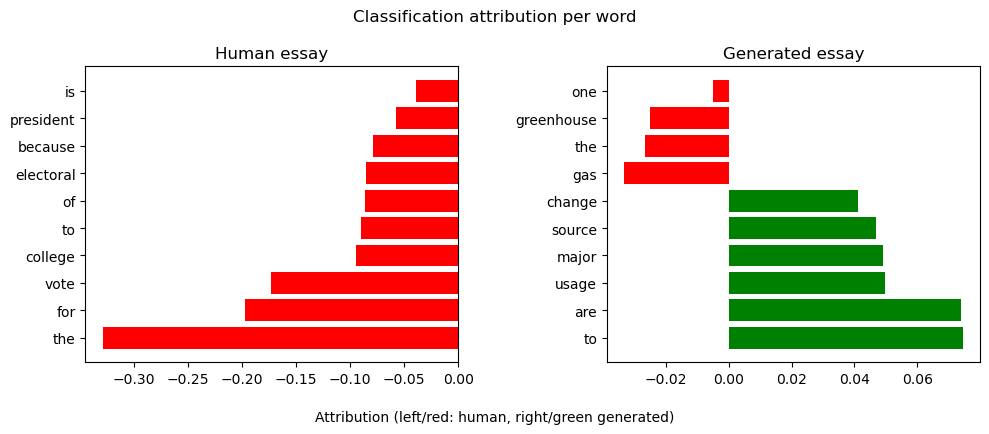

In [42]:
import matplotlib.pyplot as plt
import textwrap


# code for lime text and graph attributed to Ioannis Pavlopoulos
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(10, 4)

# explanation for (correct) human classification
example_human = data_test[(data_test.generated == 0) & (best_pred == 0)].head(256)
exp_human = explainer.explain_instance(example_human.text.iloc[0] , c.predict_proba)
exp_human_reversed = [(name, -value) for name, value in exp_human.as_list()]
word_scores_human = pd.DataFrame(exp_human.as_list(), columns=["word", "xscore"]) 
word_scores_human['color'] = word_scores_human.xscore.apply(lambda x: 'g' if x>0 else 'r')

axes[0].barh(word_scores_human.word, word_scores_human.xscore, color=word_scores_human.color)
axes[0].set_title("Human essay")

# explanation for generated classification
example = data_test[(data_test.generated == 1) & (best_pred == 1)].head(256)
exp = explainer.explain_instance(example.text.iloc[0] , c.predict_proba)
word_scores = pd.DataFrame(exp.as_list(), columns=["word", "xscore"])
word_scores['color'] = word_scores.xscore.apply(lambda x: 'g' if x>0 else 'r')

axes[1].barh(word_scores.word, word_scores.xscore, color=word_scores.color)
axes[1].set_title("Generated essay")

fig.suptitle("Classification attribution per word")
fig.text(0.5, -0.05, 'Attribution (left/red: human, right/green generated)', ha='center')
fig.tight_layout(h_pad=3, w_pad=3) #believe it or not this *is* different from pad=3

save_plot("attribution.png")
plt.show()

The results aren't very interpretable since we:
* Did not remove stopwords from the texts for the TF-IDF representation
* Use an n-gram model instead of a simple uni-gram model, meaning that certain words .

What we can gather from this graph however, is that our model may be overfitting on the current data. Our intuition would claim that simpler words, more frequently seen in the student essays, would be included in the human classification attribution compared to the generated attribution graph. Additionally, the simple fact that stopwords are included among the most important features is a good indication of overfitting.

## Analyzing the dataset

We can formulate two main hypotheses to explain the (utopic?) results reached by our classifiers:

**Hypothesis 1: Our classifier has "solved" the underlying problem**. The extremely successful results shown here indicate that the classifier has modeled the actual distribution of the data, and can thus solve it with almost perfect accuracy in unseen data.

**Hypothesis 2: The training data do not represent the underlying problem**. In that case, the extremely successful results shown here are indicative of overfitting, where both training and test data feature a fundamentally different (and more easily solvable) distribution than real-life data. This is the most probable hypothesis, and can result from low-quality data and a non-representative sample.

Of course, the only way to know which hypothesis holds with certainty is to expose our trained classifier to unseen operational data which were collected with a different method from ours (different models, prompts). We can however run analysis on our dataset to explore and optimize the quality of our generated essays.

### Text Similarity

The first step towards interpreting the results of our classifiers is to gauge the characteristics of our dataset. We can estimate how easily distinguishable the two classes (generated / human) are by calculating the similarity between each generated post compared to all human ones.

There are many similarity scores for text data, each with its own criteria, strength and weaknesses. Two of the most prominent ones are:
* Cosine Similarity, usually used for text embeddings
* Jaccard Similarity, which is applied to the raw text, and calculates the ratio of common to total words between the texts. This score is biased towards large texts and does not take into account multiple instances of a word.

For the purposes of our analysis we use the Jaccard Similarity, since the TF-IDF representation that we have chosen inherently uses the existence of words instead of their semantic meaning. Thus, the Jaccard Similarity score should be directly related to the ability of our classifiers to distinguish the classes in our dataset.

We will be computing the mean and max similarity for every generated text compared to all human texts.

In [43]:
generated_df = df[df.generated == 1]
human_df = df[df.generated == 0]

In [44]:
def jaccard_similarity(set1: set[str], set2: set[str]) -> float:
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union


mean_similarity = []
max_similarity = []

print("Calculating similarity scores...")
for x in tqdm(generated_df.text):
    similarities = []
    for y in human_df.text:
      similarities.append(jaccard_similarity(set(x.split()), set(y.split())))
                                        
    mean_similarity.append(np.mean(similarities))
    max_similarity.append(np.max(similarities))

Calculating similarity scores...


  0%|          | 0/3828 [00:00<?, ?it/s]

In [45]:
similarity_df = pd.DataFrame({"id": generated_df.id,
                              "text": generated_df.text,
                              "mean": mean_similarity,
                              "max": max_similarity})
similarity_df

,id,text,mean,max
0,2706070325550928338,cars have been a major part of our lives for a...,0.030534,0.063830
1,8304849341424211841,"limiting car usage has many advantages, such a...",0.116352,0.233607
2,-1841955124139672827,"""america's love affair with it's vehicles seem...",0.032338,0.063415
3,1491668036995756067,"cars are convenient, but they can be harmful t...",0.050623,0.100000
4,-6715567450662082236,"cars are a convenient way to get around, but t...",0.118307,0.223108
...,...,...,...,...
4391,-3058502629043601790,"dear ,\n\nhey, hope you're good! so, i've been...",0.120477,0.197101
4392,5063921888867424948,"dear ,\n\nhope this letter finds you chill. i ...",0.121238,0.194079
5097,82131f68,"this essay will analyze, discuss and prove one...",0.128805,0.222222
5133,86fe4f18,i strongly believe that the electoral college ...,0.116595,0.227488


And plot them, to get a better picture of the results:

Figured saved to ..\output\similarity.png


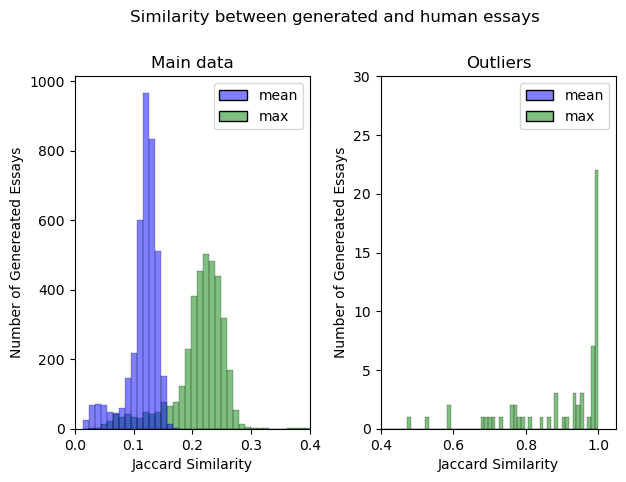

In [46]:
import seaborn as sns
import textwrap


fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle("Similarity between generated and human essays")
fig.tight_layout(pad=2.0)

sns.histplot(similarity_df, palette={"mean": "blue", "max": "green"}, ax=ax1)

ax1.set_xlim(0, 0.4)
ax1.set_xlabel("Jaccard Similarity")
ax1.set_ylabel("Number of Genereated Essays")
ax1.set_title("Main data")


sns.histplot(similarity_df, palette={"mean": "blue", "max": "green"}, ax=ax2)
ax2.set_xlabel("Jaccard Similarity")
ax2.set_ylabel("Number of Genereated Essays")
ax2.set_xlim(0.4)
ax2.set_ylim(0, 30)
ax2.set_title("Outliers")

save_plot("similarity.png")
plt.show()

The aggregated similarities are not normally distributed (significantly "fat" tails). Most generated texts are not at all similar with the human essays, although we notice some being very similar with at least one human text and more than 20 being completely identical.

Another important pattern would be if mean and max similarity are correlated. By plotting them against each other we can see a clear linear correlation between them, with many significant outliers for $mean > 0.12$

Figured saved to ..\output\similarity_mean_max.png


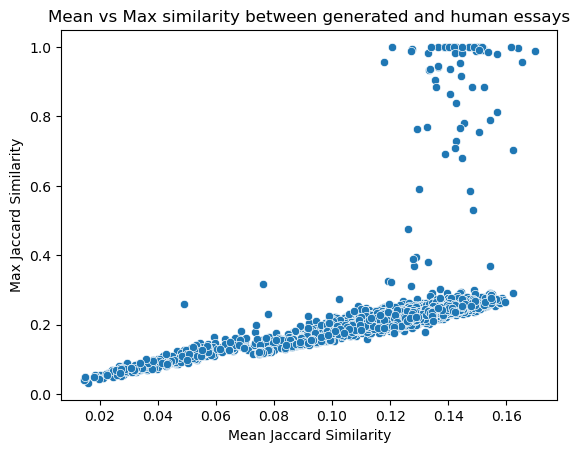

In [47]:
sns.scatterplot(x="mean", y="max", data=similarity_df)

plt.title("Mean vs Max similarity between generated and human essays")
plt.xlabel("Mean Jaccard Similarity")
plt.ylabel("Max Jaccard Similarity")

save_plot("similarity_mean_max.png")
plt.show()

We can look at some of the outliers sorted by their max similarity with all human texts:

In [48]:
outlier_df = df.merge(similarity_df[similarity_df["max"] > 0.9], how="inner", on="id")
outlier_df = outlier_df.drop("text_y", axis=1)
outlier_df = outlier_df.sort_values("max", ascending=False)
outlier_df.head(10)

,id,text_x,prompt_id,generated,llm,source,embedding,mean,max
15,-4691694311061836046,limiting the usage of cars will bring a lot of...,0,1,PaLM,Konstantina Liagkou,"[-0.5782225, 0.24332923, -2.4579358, -0.452946...",0.147191,1.0
10,-5188626884374515857,many people believe that it is necessary to us...,0,1,PaLM,Konstantina Liagkou,"[-0.33160272, -0.31828144, -1.7051255, -0.6998...",0.120713,1.0
24,5118739012745919913,as we get older we want to travel to more plac...,0,1,PaLM,Konstantina Liagkou,"[-0.79505664, 0.9531083, -3.1073515, -0.625847...",0.141897,1.0
23,-6444888010307021367,cars have always seemed to be a necessity to p...,0,1,PaLM,Konstantina Liagkou,"[-0.18551056, 0.36230952, -2.6442566, -0.78679...",0.150804,1.0
22,1828837846251354916,cars are used for transporting from place to p...,0,1,PaLM,Konstantina Liagkou,"[-0.70787483, 0.46535164, -2.4349554, -0.22792...",0.161674,1.0
21,3534328998554978368,"for years, the united states has been mass pro...",0,1,PaLM,Konstantina Liagkou,"[-0.48433185, 0.14956288, -2.5381866, -0.35953...",0.150053,1.0
19,8758329256473756660,imagine a world completely pollution free. a w...,0,1,PaLM,Konstantina Liagkou,"[-0.3619175, -0.03683313, -3.0423043, -0.35832...",0.142544,1.0
16,-7122620728386198961,the automobile has been a staple in human hist...,0,1,PaLM,Konstantina Liagkou,"[-0.5615728, 0.20120902, -2.315603, -0.6624788...",0.140410,1.0
34,-3160460727722949356,"in the united states, people are very busy. wi...",0,1,PaLM,Konstantina Liagkou,"[-0.82555705, -0.14602426, -2.5105572, -0.1629...",0.149001,1.0
12,-1938350886191480717,"for decades, society has put a major emphasis ...",0,1,PaLM,Konstantina Liagkou,"[-0.96646154, -0.009873128, -2.183229, -0.4779...",0.138937,1.0


### Leave-One-Out Cross Validation

By using LOOV-CV we can hopefully correlate the prediction probability of every generated text with its mean and max similarity with human texts, as described above. 

#### Exporting intermediary data

Since the LOOV procedure is **extremely** computationally expensive, we will offload it to [another notebook](loov.ipynb) to be executed separately (and much more sparingly).

In [49]:
import skops.io as sio


print("Exporting model...")
sio.dump(best_model, os.path.join(notebook_config.INTERMEDIATE_DIR, 
                                  notebook_config.MODEL_FILE_NAME))
print("Model exported")

Exporting model...
Model exported


In [50]:
df.to_csv(os.path.join(notebook_config.INTERMEDIATE_DIR, 
                       notebook_config.LOOV_INPUT_NAME))

#### Running LOOV analysis

We retrieve the results of our LOOV. While the results do not include every single generated text due to computational cost, we do not need all texts. 

This section is about analyzing the correlation between mean/max text similarity and prediction probability, and thus we only need a representative sample, large enough for our conclusions to be statistically significant.

More specifically, we are looking for data points that are likely to have low prediction probability, meaning that they sufficiently "confuse" the classifier. Those data points are much more valuable to us than clearly generated texts which the classifier can trivially distinguish.

In [51]:
res_df = pd.read_csv(os.path.join(notebook_config.INTERMEDIATE_DIR, 
                                  notebook_config.LOOV_RES_NAME))
res_df = res_df.drop("Unnamed: 0", axis=1)
res_df.id = res_df.id.astype(str)

analysis_df = res_df.merge(similarity_df, 
                           how="inner", 
                           on="text", 
                           suffixes=("", "_x"))
analysis_df = analysis_df.drop("id_x", axis=1)
analysis_df

,id,text,proba,mean,max
0,4939831770751659793,"dear senator,\r\n\r\ni am writing to you today...",1.000000,0.125151,0.223529
1,-5181558583334583137,"dear senator,\r\n\r\ni am writing to you today...",1.000000,0.124485,0.267677
2,2366576317616977003,having to deal with traffic jams and having to...,1.000000,0.145804,0.248366
3,-1968555983985476503,**limiting car usage**\r\n\r\ncars are a conve...,1.000000,0.108858,0.183673
4,5004929736231301463,cars have become an essential part of our dail...,0.970580,0.126037,0.210031
...,...,...,...,...,...
598,-7965903384765500156,"dear senator,\r\n\r\ni am writing to you today...",0.999117,0.127327,0.235507
599,7537948682280034878,"dear state senator,\r\n\r\ni am writing to you...",0.994704,0.146585,0.262799
600,-3503307469460722422,"walk, bike, or take public transportation. dea...",0.998235,0.135283,0.247059
601,-2917229996352852675,"dear senator,\r\n\r\ni am writing to you today...",1.000000,0.131249,0.246862


Normal statistical analysis in this case is going to be very challenging, since (as stated above) the distributions of the mean/max similarity are not normal and definitely not homoscedastic. Thus, most traditional statistical models would fail at accurately describing their relationship.

Instead, we can draw conclusions graphically, if those are apparent enough:

Figured saved to ..\output\diversity_plot.png


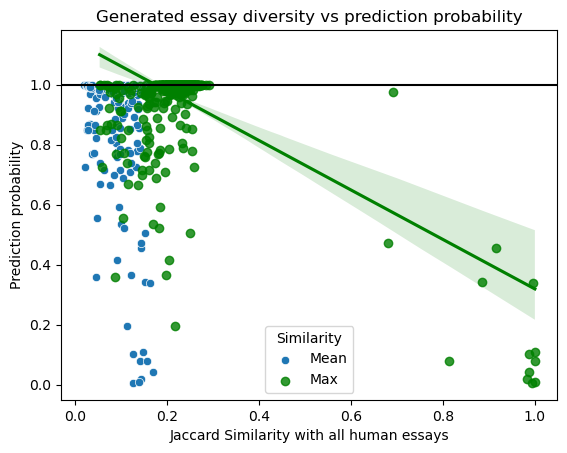

In [52]:
sns.scatterplot(x="mean", y="proba", data=analysis_df)
sns.regplot(x="max", y="proba", color="green", data=analysis_df)

plt.axhline(1, color="black")
plt.title("Generated essay diversity vs prediction probability")
plt.ylabel("Prediction probability")
plt.xlabel("Jaccard Similarity with all human essays")
plt.legend(title='Similarity', labels=['Mean', 'Max'], loc="lower center")

save_plot("diversity_plot.png")
plt.show()

#### Conclusions

We notice a slight inverse trend between max similarity and prediction probability. Obviously, when similarity becomes 1, or very close to 1, the classifier fails since the data point itself is mislabeled. There are a few valuable points, but most reside in an area of low similarity with human texts and very high prediction probability.

The conclusions we draw from this graph therefore are:
* Some of the generated essays are clearly copied by the LLM, and thus functionally useless.
* Most points are irrelevant with regards to prediction probability
* There is a slight inverse relationship between max similarity and prediction probability, meaning that, in general, essays that are more similar to human texts tend to be more valuable for the classifier.

### Selecting the optimal training dataset

Based on the conclusions drawn from the analyses above, we can create an "optimal" dataset which comprises the most valuable generated texts. 

Quality in this case is defined by:
* Any generated text which is separable with human texts (texts with at most 95% max similarity with human texts)
* Generated texts with as high max similarity with human texts as possible. Since mean and max similarity are clearly positively correlated, selecting texts with high similarity means they also feature high mean similarity.

We achieve this dataset by filtering out the non-separable texts and filling the new dataset with a subset of generated texts sorted by max similarity. We choose to generate a completely balanced dataset, since we don't know the underlying population and thus the a-priori probabilities of each class. We also balance our dataset in respect to the prompt used in order to not fit a classifier trained only on one of the possible essay subjects.

In [53]:
# remove non-separable texts
optimal_df = df.merge(similarity_df.loc[:, ["id", "max"]], how="outer", on="id")
optimal_df = optimal_df[~(optimal_df["max"] > 0.95)]
optimal_df

,id,text,prompt_id,generated,llm,source,embedding,max
0,2706070325550928338,cars have been a major part of our lives for a...,0,1,PaLM,Konstantina Liagkou,"[0.08063801, 1.6982207, -2.530246, -0.46471617...",0.063830
1,8304849341424211841,"limiting car usage has many advantages, such a...",0,1,PaLM,Konstantina Liagkou,"[-0.8870298, -0.45862535, -3.3064713, -0.09198...",0.233607
2,-1841955124139672827,"""america's love affair with it's vehicles seem...",0,1,PaLM,Konstantina Liagkou,"[0.9119747, 1.0349286, -1.5265588, -2.3698876,...",0.063415
3,1491668036995756067,"cars are convenient, but they can be harmful t...",0,1,PaLM,Konstantina Liagkou,"[-0.90010715, -0.37471777, -3.003909, -0.01778...",0.100000
4,-6715567450662082236,"cars are a convenient way to get around, but t...",0,1,PaLM,Konstantina Liagkou,"[-0.083860934, -0.271521, -3.4049506, -0.04745...",0.223108
...,...,...,...,...,...,...,...,...
5206,fe6ff9a5,there has been a fuss about the elector colleg...,1,0,Human,Competition,"[-1.4767352, 0.04409365, -2.265938, 0.2277243,...",NaN
5207,ff669174,limiting car usage has many advantages. such a...,0,0,Human,Competition,"[-0.20308205, 0.864372, -3.5353804, 0.25371215...",NaN
5208,ffa247e0,there's a new trend that has been developing f...,0,0,Human,Competition,"[-0.80689734, 0.0152280945, -2.0881786, -0.199...",NaN
5209,ffc237e9,as we all know cars are a big part of our soci...,0,0,Human,Competition,"[-0.65920925, 0.18932514, -2.4064806, -0.80102...",NaN


In [54]:
# balance dataset with highest quality essays
human_len = df[df.generated==0].shape[0]

new_generated_cars = optimal_df[(optimal_df.generated == 1)
                                & (optimal_df.prompt_id == 0)
                                ].sort_values("max", ascending=False)[:human_len//2]
new_generated_elect = optimal_df[(optimal_df.generated == 1) 
                                & (optimal_df.prompt_id == 1)
                                ].sort_values("max", ascending=False)[:human_len//2]

optimal_df = pd.concat([optimal_df[optimal_df.generated == 0], 
                        new_generated_cars,
                        new_generated_elect], ignore_index=True)

optimal_df = optimal_df.drop("max", axis=1)
optimal_df

,id,text,prompt_id,generated,llm,source,embedding
0,0059830c,cars. cars have been around since they became ...,0,0,Human,Competition,"[-0.9639097, 0.15837152, -2.1686153, -0.057272..."
1,005db917,transportation is a large necessity in most co...,0,0,Human,Competition,"[-1.2354518, -0.09898801, -2.1328986, 0.258718..."
2,008f63e3,"""america's love affair with it's vehicles seem...",0,0,Human,Competition,"[-0.37253016, 0.15195324, -2.0611265, -0.86810..."
3,00940276,how often do you ride in a car? do you drive a...,0,0,Human,Competition,"[-0.47272915, 0.18846808, -2.2762864, -0.72999..."
4,00c39458,cars are a wonderful thing. they are perhaps o...,0,0,Human,Competition,"[-0.1297419, 0.26021686, -2.2862716, -0.554875..."
...,...,...,...,...,...,...,...
2744,-9192769563779804984,"dear senator,\r\n\r\ni am writing to you today...",1,1,PaLM,Konstantina Liagkou,"[-1.8761305, -0.35899234, -1.6677326, 1.003489..."
2745,4050626118615851695,"dear senator,\n\ni am writing to you today to ...",1,1,PaLM,Muhammad Rizqi,"[-1.6038033, -0.05741547, -1.8774744, 0.784811..."
2746,1680287988459021068,"dear senator,\n\ni am writing to you today to ...",1,1,PaLM,Muhammad Rizqi,"[-1.9409627, -0.45065603, -1.6456604, 0.884694..."
2747,-8775247381239926910,"dear senator,\r\n\r\ni am writing to you today...",1,1,PaLM,Konstantina Liagkou,"[-1.8322563, 0.011716413, -1.8163607, 1.516939..."


### Impact of data size

Since disregarding the data may lead to lower performance, we can plot the performance of our classifier for different sized datasets to estimate the theoretical best data size.

We split the training data into $[10\%, 20\%, \cdots, 100\%]$ random splits, leaving the test set as-is. We then train our best classifier in all of the successive splits and keep the accuracy metric. 

In [55]:
optimal_data_train, optimal_data_test = train_test_split(optimal_df,
                                                         train_size=0.7, 
                                                         test_size=0.3,
                                                         random_state=42)

In [56]:
len_splits = np.arange(start=0.1, stop=1.1, step=0.1)
splits = [optimal_data_train.sample(int(np.ceil(optimal_data_train.shape[0]*i))) for i in len_splits]

sizes = [len(split) for split in splits]
sizes

[193, 385, 578, 770, 962, 1155, 1347, 1540, 1732, 1924]

In [57]:
from sklearn.metrics import f1_score
from sklearn.base import clone


train_scores = []
test_scores = []

print("Running classifier on multiple training splits...")
for split in tqdm(splits):
    x_train = vectorizer.fit_transform(split.text)
    y_train = split.generated
    x_test = vectorizer.transform(optimal_data_test.text)
    y_test = optimal_data_test.generated
    
    model = clone(best_model)
    model = model.fit(x_train, y_train)

    train_preds = model.predict(x_train)
    train_scores.append(f1_score(y_train, train_preds, average="macro"))
    test_preds = model.predict(x_test)
    test_scores.append(f1_score(y_test, test_preds, average="macro"))

train_scores = np.array(train_scores)
test_scores = np.array(test_scores)

Running classifier on multiple training splits...


  0%|          | 0/10 [00:00<?, ?it/s]

We now plot the accuracy metric (here Macro-F1 score for reasons outlined in the `Classifiers` section) in relation to the number of data points. 

A useful question would be how much data would we need to reach 100% test set accuracy. Since it's improbable that our classifier can reach this score with a reasonable amount of data we resort to using a regression plot on the test set accuracy metric. This has several caveats:
* The linearity assumption made by the (linear) regression plot is almost never accurate in training/test curves. The curves are oftentimes logarithmic, rapidly improving when only few data points exist, and plateauing after a certain inflection point. For example, the performance of a classifier will improve more when we add 10 points from a previous dataset of 100, than if we add the same amount of points to a previous dataset of 10,000
* The shape of the curve will angle the regression line upwards since the first splits will almost certainly be much "lower" than the rest

Concluding, while we certainly can use a linear regression line to gauge the amount of data until we reach 100% test set accuracy, this prediction will almost certainly be overly optimistic.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Figured saved to ..\output\dataset_size.png


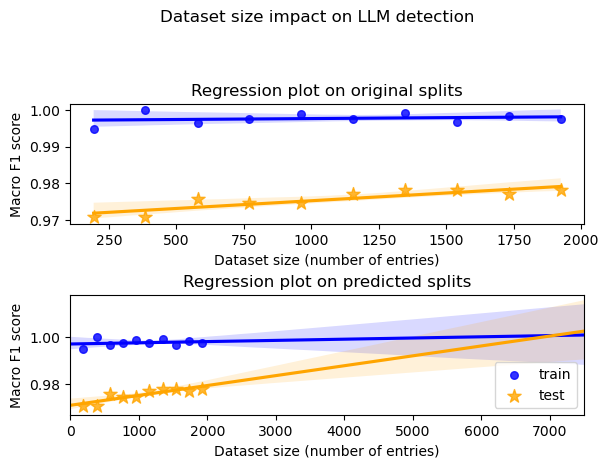

In [58]:
fig, (ax1, ax2) = plt.subplots(2, 1)
fig.suptitle("Dataset size impact on LLM detection")
fig.tight_layout(pad=3)

# regular regplot
sns.regplot(y=train_scores, 
            x=sizes, 
            label="train", 
            color="blue", 
            ax=ax1,
            scatter_kws={"s": 30})
sns.regplot(y=test_scores,
            x=sizes,
            label="test",
            color="orange",
            marker="*", 
            ax=ax1,
            scatter_kws={"s": 100})

ax1.set_title("Regression plot on original splits")
ax1.set_ylabel("Macro F1 score")
ax1.set_xlabel("Dataset size (number of entries)")
plt.legend()


# regplot with expanded xlim
plt.xlim(0, 7500)
sns.regplot(y=train_scores, 
            x=sizes, 
            label="train", 
            color="blue", 
            ax=ax2,
            scatter_kws={"s": 30},
            truncate=False)
sns.regplot(y=test_scores,
            x=sizes,
            label="test",
            color="orange",
            marker="*", 
            ax=ax2,
            scatter_kws={"s": 100},
            truncate=False)

ax2.set_title("Regression plot on predicted splits")
ax2.set_ylabel("Macro F1 score")
ax2.set_xlabel("Dataset size (number of entries)")


plt.legend()
# save and show
save_plot("dataset_size.png")
plt.show()

#### Conclusions:

We notice the following important patterns:
* The training F1-score remains at 100% irrespective of dataset size. This can be explained by the very low mean similarity scores between the generated and human texts. 
* The testing F1-score improves for a dataset of size up to 1100, at which point it oscillates around 95% testing F1-score
* The convergence point of 100% testing score happens at approximately 7000 data points. However, we can be certain this is a very optimistic estimate for the reasons outlined above.

## Clustering-based augmentation

In order to determine the "variance" of our generated samples, we can use clustering techniques to determine in which groups the human and generated essays belong in. Using those groups we can extract their similarities by looking into their individual members, and determine which groups may be underrepresented in our dataset.

### Methodology

Before we execute the clustering algorithm we need to determine the number of clusters in our data. This can be either done by intuition (if we already know how many classes *should* exist according to our problem), or by statistical techniques.

Our intuition would lead us to choose $2$ clusters for both generated and human essays, one for each prompt. However, we are interested in seeing if there are underlying patterns within those two large clusters, which is why we need to use the aforementioned techniques.

There are two main methods we can use to determine the number of clusters, the **Elbow** method and the **Silhouette** score. To simplify, the Elbow method determines the last point at which the model improves significantly while the Silhouette score determines the cluster cohesion. 

We follow the advice of [this post](https://builtin.com/data-science/elbow-method), which warns against relying on the Elbow method when its results are not decisive (which is often the case), and thus use both methods.

### Clustering Generated Essays

#### Determining the number of clusters

In [59]:
generated_df = optimal_df[optimal_df.generated == 1]
human_df = optimal_df[optimal_df.generated == 0]

x_generated = vectorizer.transform(generated_df.text).toarray()
x_human = vectorizer.transform(human_df.text).toarray()

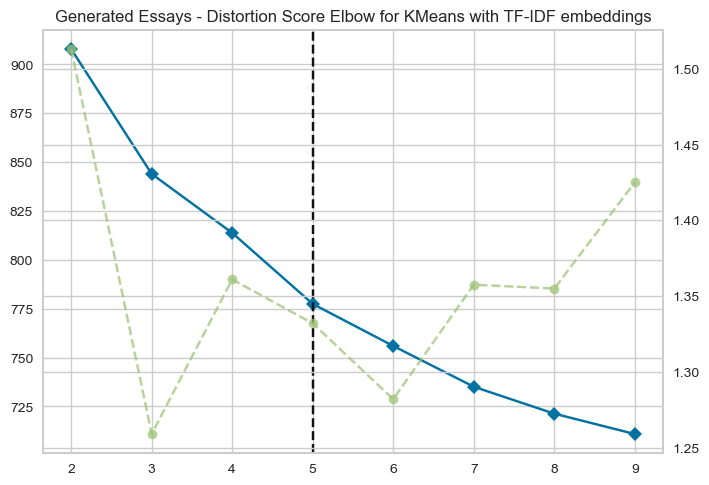

In [60]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer


# code for the graphs adapted from https://builtin.com/data-science/elbow-method

# there is an internal memory leak here, don't worry about it
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    km = KMeans(random_state=42, n_init=5)
    visualizer = KElbowVisualizer(km, k=(2,10))
    visualizer.fit(x_generated)        
    
plt.title("Generated Essays - Distortion Score Elbow for KMeans with TF-IDF embeddings")
plt.show()

While the Elbow method indicates that 4 clusters are optimal, there is no desicive "elbow" at any point in the graph. Thus, we will use the Silhouette method to hopefully get more reliable results.

Generating plots...


  0%|          | 0/6 [00:00<?, ?it/s]

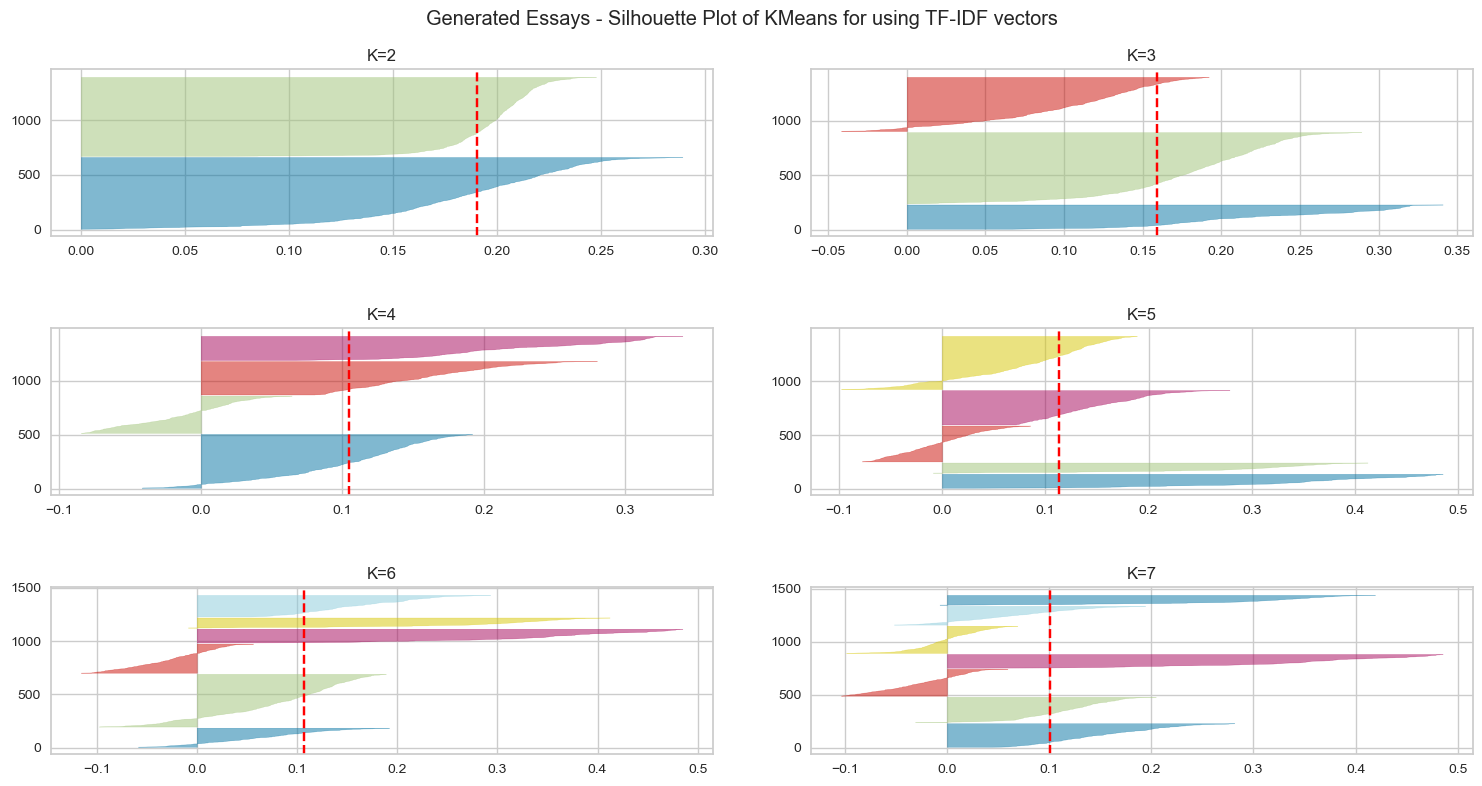

In [61]:
from yellowbrick.cluster import SilhouetteVisualizer


fig, axes = plt.subplots(3, 2, figsize=(15,8))

print("Generating plots...")
for i in tqdm(range(2, 8)):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        km = KMeans(n_clusters=i, init='k-means++', n_init=5, random_state=42)
        
        q, mod = divmod(i, 2)
        ax = axes[q-1][mod]
        ax.set_title(f"K={i}")
        
        visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax)
        visualizer.fit(x_generated) 

fig.suptitle("Generated Essays - Silhouette Plot of KMeans for using TF-IDF vectors")
fig.tight_layout(h_pad=3, w_pad=3)
plt.show()

These graphs represent how similar the points in each cluster with each other compared to the ones from other clusters. The bigger the score, the more "sure" we are the point belongs in the cluster, while negative values indicate the point has probably been mis-clustered. Each "blob" represents a cluster and the red line is the mean Silhouette score of all clusters.

We are looking for two main patterns in the graphs (we direct the reader to the [previous post](https://builtin.com/data-science/elbow-method) for details):
* All clusters must pass through the red line (all clusters must be significant)
* The cluster sizes should be as equal as possible.

Taking into account the two criteria, the optimal clustering for generated essays is $K=2$.

#### Determining the clusters

In order to qualitatetively assess the clustering we need to take a look at the clusters ourselves. The easiest and most reliable way is to print out a sample of each cluster and compare them.

In [62]:
def print_clusters(clusters: np.ndarray, data_df: pd.DataFrame, n_samples: int=2) -> None:
    """
    Print samples from each cluster along with the corresponding cluster label.

    :param clusters: An array containing cluster labels.
    :type clusters: array-like
    :param data_df: A pandas DataFrame containing text data.
    :type data_df: pd.DataFrame
    :param n_samples: An integer specifying the number of samples to print for each cluster. Default is 2.
    :type n_samples: int

    :return: None
    """
    for cluster in np.unique(clusters):
        print("=" * 100)
        print(f"Cluster {cluster}")
        for text in data_df[clusters==cluster].sample(n_samples).text:
            print("\t\t", text)

In [63]:
km = KMeans(n_clusters=2, 
            init="k-means++", 
            random_state=42, 
            n_init=10)
generated_clusters = km.fit_predict(x_generated)
print_clusters(generated_clusters, generated_df)

Cluster 0
		 in recent years, there has been a growing movement to limit car usage in order to improve our environment, our health, and our quality of life. there are many advantages to limiting car usage, and this essay will discuss three of the most important ones.

first, limiting car usage can help to reduce air pollution. cars are a major source of air pollution, and the emissions from cars can cause a variety of health problems, including asthma, heart disease, and cancer. by limiting car usage, we can reduce the amount of air pollution in our environment and improve our health.

second, limiting car usage can help to reduce traffic congestion. traffic congestion is a major problem in many cities around the world, and it can cause a lot of problems for people trying to get around. by limiting car usage, we can reduce traffic congestion and make it easier for people to get around.

third, limiting car usage can help to make our cities more livable. cars take up a lot of space in o

In [64]:
generated_cluster_mapping = {
    0: "Car-Free cities", 
    1: "Electoral College"
}

It looks like the essays have been clustered according to their prompt, which confirms our intuition.

### Clustering Human Essays

#### Determining the number of clusters

We begin with the Elbow method, just like before.

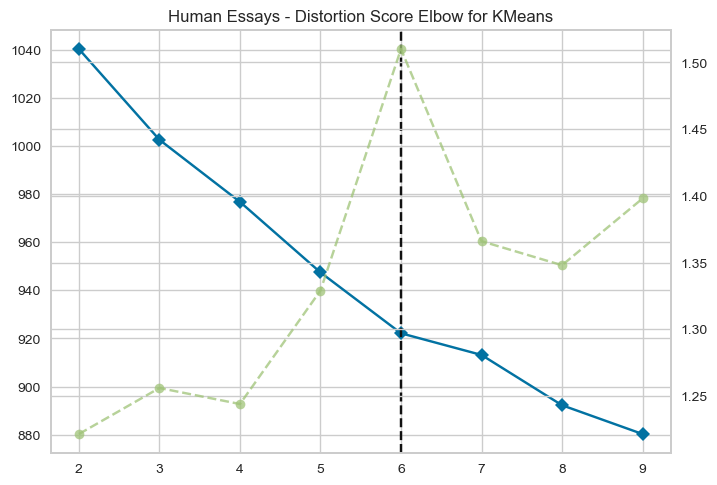

In [65]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    km = KMeans(random_state=42, n_init=5)
    visualizer = KElbowVisualizer(km, k=(2,10))
    visualizer.fit(x_human)        
    
plt.title("Human Essays - Distortion Score Elbow for KMeans")
plt.show()

This is an even more perplexing elbow graph, so we turn to Silhouette score to get a better picture.

Generating plots...


  0%|          | 0/6 [00:00<?, ?it/s]

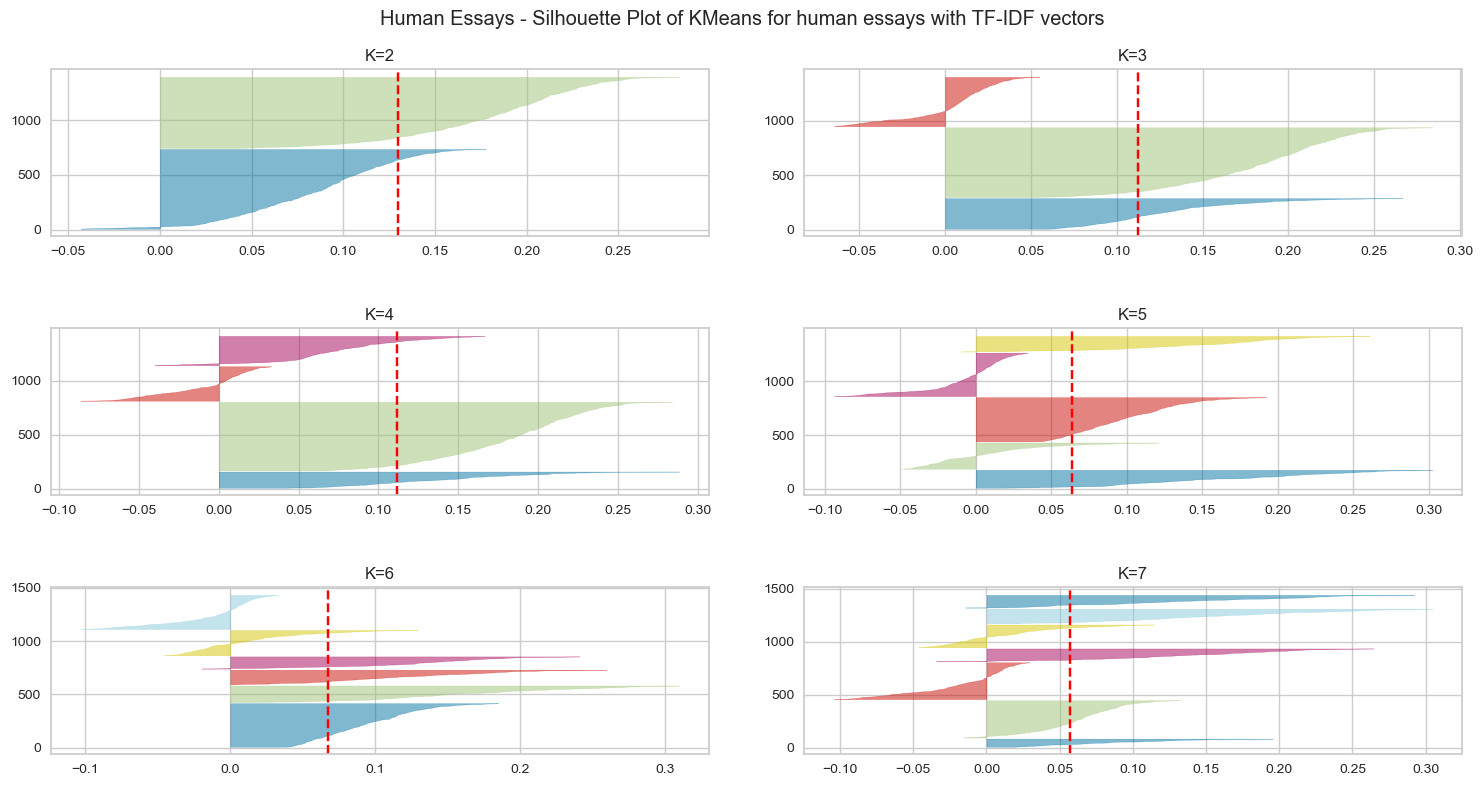

In [66]:
fig, axes = plt.subplots(3, 2, figsize=(15,8))

print("Generating plots...")
for i in tqdm(range(2, 8)):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        km = KMeans(n_clusters=i, init='k-means++', n_init=5, random_state=42)
        
        q, mod = divmod(i, 2)
        ax = axes[q-1][mod]
        ax.set_title(f"K={i}")
        
        visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax)
        visualizer.fit(x_human) 

fig.suptitle("Human Essays - Silhouette Plot of KMeans for human essays with TF-IDF vectors")
fig.tight_layout(h_pad=3, w_pad=3)
plt.show()

While we could accept $K=2$ for the same merits as in the generated essays, we must acknowledge that the clustering is much more difficult in our case. A probable reason for that is that the TF-IDF representation on which the clustering is based on, is insufficient for the human essays, either due to its shape in the $l$ dimensional space, or because of sparsity.

A way to circumvent this limitation is swapping the text representation to the Word2Vec embeddings. While probably insufficient for classification, their low dimensionality and their much higher similarity with each other (which was determined in a previous version of this notebook) make them suitable candidates for clustering.

Generating plots...


  0%|          | 0/6 [00:00<?, ?it/s]

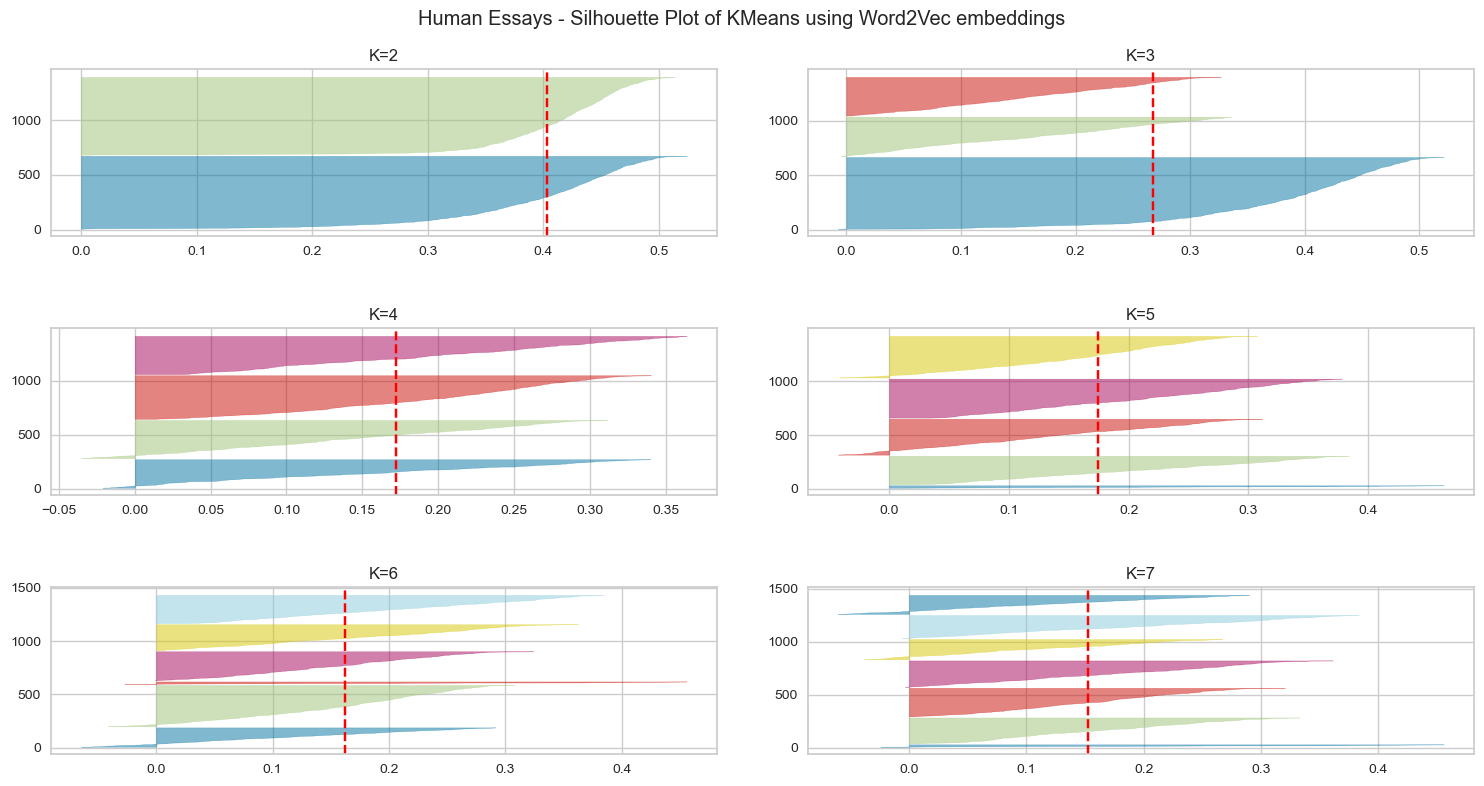

In [67]:
embed_human = np.array([x for x in optimal_df.loc[optimal_df.generated==0].embedding])
fig, axes = plt.subplots(3, 2, figsize=(15,8))

print("Generating plots...")
for i in tqdm(range(2, 8)):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        km = KMeans(n_clusters=i, init='k-means++', n_init=5, random_state=42)
        
        q, mod = divmod(i, 2)
        ax = axes[q-1][mod]
        ax.set_title(f"K={i}")
        
        visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax)
        visualizer.fit(embed_human) 

fig.suptitle("Human Essays - Silhouette Plot of KMeans using Word2Vec embeddings")
fig.tight_layout(h_pad=3, w_pad=3) 
plt.show()

This is a much clearer graph, carrying very important information; unlike the generated clusters, the human essays seem to feature underlying patterns in their 2 main clusters, making the optimal clustering $K=4$.

#### Determining the clusters

We follow the same procedure as before:

In [68]:
km = KMeans(n_clusters=4, 
                init="k-means++", 
                random_state=42, 
                n_init=10)
km = km.fit(embed_human)
human_clusters = km.predict(embed_human)
print_clusters(human_clusters, human_df)

Cluster 0
		 the wheel was the first step that took society into the making of the mobile car. today millions of cars are made each year to help humans transport around the cities and streets around the world. every vehicle that is powered by gasoline emits carbon dioxide, this gas is very harmful for the environment, it causes the ozone later to slowly dissolve and it also causes acid rains. traffic jams is one of the many effects of having too many cars in a certain populated area. debt has also been an influential part in the quantity of cars around the globe. car usage and production should be drastically reduced to ensure a better future for all living things in the planet earth.

furthermore, global warming has slowly made its toll on earth, most of which has been produced by the carbon dioxide gases in the atmosphere, this gas is a mayor green house gas. over the years cars have been more extensively used and have a great percentage in world contamination, as stated in article 1

Clusters 0 and 3 seem to feature prompts about car-free cities, while clusters 1 and 2 about the electoral college, corresponding to clusters 0 and 1 of the generated essay clusters respectively. 

The most notable difference between the clusters featuring the same prompts is that clusters 0 and 1 appear to stick closely to sources, citing them explicitly and often, and being much more likely to use text found in the sources themselves. Thus, we can yield a title for each cluster:

In [69]:
cluster_mapping = {0: "Cars w/sources", 
                   1: "Election w/sources",
                   2: "Election no sources",
                   3: "Cars no sources"}

### Relating the two clusterings

By printing some representatives from each clustering, it's clear that both are broadly split in regards to the prompt, one cluster belonging to the Electoral College and the other to Car-Free cities. However, human essays are also split in two sub-clusters for each prompt, which can be seen both from the Silhouette graphs, and the printed samples above.

Thus, it's easy to conclude that $Cluster_{generated,0} \rightarrow \{Cluster_{human, 0}, Cluster_{human, 3}\}$ and $Cluster_{generated,1} \rightarrow \{Cluster_{human, 1}, Cluster_{human, 2}\}$. While we could use a hierarchical clustering algorithm to confirm, our results are intuitive, clearly represented in the printed representatives, and justified by the Silhouette plots. Thus, we can rely on this qualitative conclusion without utilizing quantitative metrics (such as mean distance between clusterings) and taking the risk of False-Negative results.

### Determining the balance of the clusters

In order to get a faithful representation of the student essays by our generated dataset, we should ensure that the generated essays correspond roughly proportionally to the student clusters. 

We will cluster the generated essays according to the K-means model we trained on human essays and compare the number of essays in each cluster:

In [70]:
embed_generated = np.array([x for x in optimal_df.loc[optimal_df.generated==1].embedding])
guessed_gen_clusters = km.predict(embed_generated)

In [71]:
cluster_df = pd.DataFrame({"cluster": np.concatenate([
                                guessed_gen_clusters, 
                                human_clusters]),
                          "generated": np.concatenate([
                              np.ones_like(guessed_gen_clusters), 
                              np.zeros_like(human_clusters)])})

cluster_df.cluster = cluster_df.cluster.map(cluster_mapping)
cluster_df

,cluster,generated
0,Cars no sources,1
1,Cars no sources,1
2,Cars w/sources,1
3,Cars w/sources,1
4,Cars w/sources,1
...,...,...
2744,Election no sources,0
2745,Cars no sources,0
2746,Cars w/sources,0
2747,Cars no sources,0


Figured saved to ..\output\clusters.png


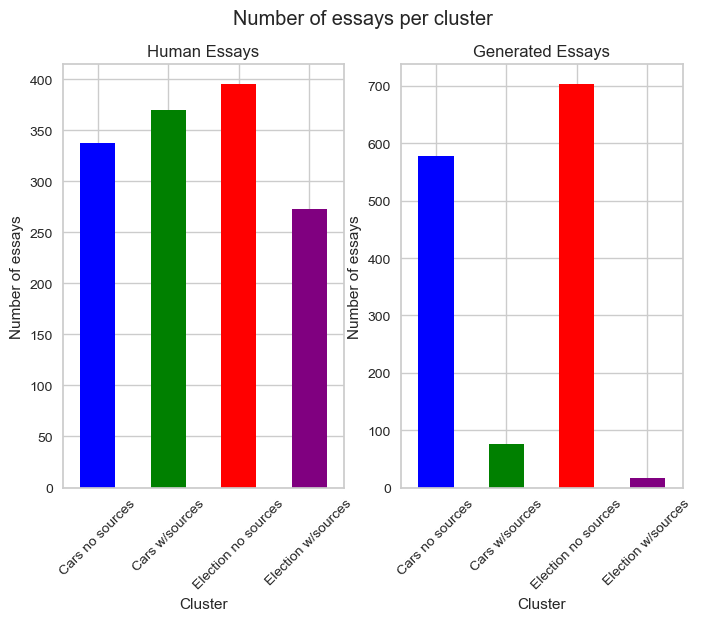

In [72]:
fig, (ax1, ax2) = plt.subplots(1, 2)

cluster_human_df = cluster_df[cluster_df.generated == 0]
cluster_human_df.cluster.value_counts().sort_index().plot(
    kind='bar', 
    color=['blue', 'green', 'red', 'purple'],
    ax=ax1)
ax1.set_title("Human Essays")
ax1.set_xlabel("Cluster")
ax1.set_ylabel("Number of essays")
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)


gen_human_df = cluster_df[cluster_df.generated == 1]
gen_human_df.cluster.value_counts().sort_index().plot(
    kind='bar', 
    color=['blue', 'green', 'red', 'purple'],
    ax=ax2)
ax2.set_title("Generated Essays")
ax2.set_xlabel("Cluster")
ax2.set_ylabel("Number of essays")
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)

fig.suptitle("Number of essays per cluster")
save_plot("clusters.png")
plt.show()

Considering we applied the human clustering to the generated texts, the significant label imbalance may be a case of significant differences between the two clustering models, and not representative of an actual issue with our texts. Our earlier clustering for generated texts clearly indicates the presence of two homogeneous and clearly separate clusters, which do not seem to feature the natural sub-clusters of human texts. 

As such this imbalance is probably a product of the minimal variety encountered in generated texts.

### Dataset augmentation

Regardless we can explicitly prompt ChatGPT to generate more varied essays in accordance with the above categories and add its responses to our dataset:

In [73]:
extra_cars_df = create_dataset(read_gpt("cluster_augmentation_cars.md"), 
                               prompt_id=0, 
                               llm="ChatGPT", 
                               source="Dimitris Tsirmpas")

extra_elect_df = create_dataset(read_gpt("cluster_augmentation_election.md"), 
                               prompt_id=1, 
                               llm="ChatGPT", 
                               source="Dimitris Tsirmpas")
extra_df = pd.concat([extra_cars_df, extra_elect_df], ignore_index=True)
extra_df.head()

,id,text,prompt_id,generated,llm,source
0,-2938169421318245979,In the evolving landscape of urban planning an...,0,1,ChatGPT,Dimitris Tsirmpas
1,8276795719208280689,"In today's rapidly changing world, the idea of...",0,1,ChatGPT,Dimitris Tsirmpas
2,-5354302341786345557,In the fast-paced and ever-evolving world of t...,0,1,ChatGPT,Dimitris Tsirmpas
3,-1053693716709022087,"In recent years, the notion of limiting car us...",0,1,ChatGPT,Dimitris Tsirmpas
4,5867441763791249468,"In recent years, there has been a growing move...",0,1,ChatGPT,Dimitris Tsirmpas


### Training the best classifier with the augmented data

We can now retrain our best classifier with the extra data and check whether our more balanced dataset helps improve its performace.

In [74]:
extra_df_prepr = extra_df.copy()
extra_df_prepr.text = preprocess(extra_df_prepr.text)
extra_df_prepr["embedding"] = compute_embeddings(extra_df_prepr.text) 

augmented_df_prepr = pd.concat([extra_df_prepr, optimal_df])
augmented_df_prepr

Removing stopwords...


  0%|          | 0/118 [00:00<?, ?it/s]

Computing embeddings...


  0%|          | 0/118 [00:00<?, ?it/s]

,id,text,prompt_id,generated,llm,source,embedding
0,-2938169421318245979,in the evolving landscape of urban planning an...,0,1,ChatGPT,Dimitris Tsirmpas,"[-0.93227756, 0.13992345, -2.0261798, 0.444238..."
1,8276795719208280689,"in today's rapidly changing world, the idea of...",0,1,ChatGPT,Dimitris Tsirmpas,"[-1.02964, -0.03597131, -1.9895343, 0.1121118,..."
2,-5354302341786345557,in the fast-paced and ever-evolving world of t...,0,1,ChatGPT,Dimitris Tsirmpas,"[-1.0780069, -0.06127779, -1.8729239, 0.232408..."
3,-1053693716709022087,"in recent years, the notion of limiting car us...",0,1,ChatGPT,Dimitris Tsirmpas,"[-1.1014526, -0.09193605, -1.9376906, 0.394605..."
4,5867441763791249468,"in recent years, there has been a growing move...",0,1,ChatGPT,Dimitris Tsirmpas,"[-1.0529733, -0.22231708, -1.847859, 0.3483477..."
...,...,...,...,...,...,...,...
2744,-9192769563779804984,"dear senator,\r\n\r\ni am writing to you today...",1,1,PaLM,Konstantina Liagkou,"[-1.8761305, -0.35899234, -1.6677326, 1.003489..."
2745,4050626118615851695,"dear senator,\n\ni am writing to you today to ...",1,1,PaLM,Muhammad Rizqi,"[-1.6038033, -0.05741547, -1.8774744, 0.784811..."
2746,1680287988459021068,"dear senator,\n\ni am writing to you today to ...",1,1,PaLM,Muhammad Rizqi,"[-1.9409627, -0.45065603, -1.6456604, 0.884694..."
2747,-8775247381239926910,"dear senator,\r\n\r\ni am writing to you today...",1,1,PaLM,Konstantina Liagkou,"[-1.8322563, 0.011716413, -1.8163607, 1.516939..."


In [75]:
data_train, data_test = train_test_split(augmented_df_prepr,
                                        train_size=0.7,
                                        test_size=0.3,
                                         random_state=42)
data = get_data_from_text(vectorizer, data_train, data_test)

final_x_train = data["x_train"]
final_y_train = data["y_train"]
final_x_test = data["x_test"]
final_y_test = data["y_test"]

Since we fundementally changed the training dataset we need to run a new hyper-parameter search for our classifier. We do not need to consider other classifiers however, since both datasets originate from the same distribution.

In [76]:
search.fit(final_x_train, final_y_train)
final_best_model = search.best_estimator_
final_best_model

RandomForestClassifier(criterion='entropy', n_estimators=483, n_jobs=-1)

In [77]:
res = cross_val_res(final_best_model, final_x_train, final_y_train)
print(f"Best model with optimized dataset Macro-F1:\n mean:{res[0]:.4f}, std: {res[1]:.4f}")

Best model with optimized dataset Macro-F1:
 mean:0.9730, std: 0.0080


In [78]:
best_model = final_best_model.fit(final_x_train, final_y_train)
preds = final_best_model.predict(final_x_test)

print(classification_report(final_y_test, preds))

              precision    recall  f1-score   support

           0       0.96      0.99      0.97       438
           1       0.99      0.96      0.97       423

    accuracy                           0.97       861
   macro avg       0.97      0.97      0.97       861
weighted avg       0.97      0.97      0.97       861



We can see that our classifier has noticebly improved, as did its training time.

Additonally, we can be more optimistic about its ability to generalize on the operational dataset, since this score was achieved after getting rid of most low-quality datapoints. Many of these data points included "low-hanging fruit", or in other words texts that had no similarity with any human text, and thus served to pad the classifier's accuracy upwards as well as most likely overfitting it.

## Exporting the full dataset

The full dataset comprises the (few) generated prompts provided to us as well as all the generated prompts we generated (even if only a subset was used for the purposes of this notebook).

Asides from meta-information included in the original dataset we also include the "model" and "source" columns defined earlier, as well as a column denoting whether the text was deemed of enough quality to be used in the training dataset. Finally, we add a column representing the cluster of each essay according to the K-Means model fitted on the human essays.

The final, formatted augmentation dataset can be found at [output/augmentation.csv](output/augmentation.csv). The file is structured as follows:

| Column | Type | Description  |
|---|---|---|
| id  | string | A unique identifier for the essay  |
| text  | string | The text of the essay  |
|  prompt_id | integer |  Which prompt the essay was generated from, relates to [data/train_prompts.csv](data/train_prompts.csv) |
| generated | integer | Whether the essay was generated by an LLM, all 1  |
| cluster |  integer | The assigned cluster of the text, as described in the notebook |  
| LLM |  string | The LLM which generated the essay |
| source |  string | Dataset attribution |
| gold | integer | Whether the dataset was used in the final training phase of the LLM detector. These essays are considered the highest quality amongst the dataset, as explained in the notebook |

In [79]:
full_df = pd.concat([extra_cars_df, original_df[original_df.generated==1]])
full_df

,id,text,prompt_id,generated,llm,source
0,-2938169421318245979,In the evolving landscape of urban planning an...,0,1,ChatGPT,Dimitris Tsirmpas
1,8276795719208280689,"In today's rapidly changing world, the idea of...",0,1,ChatGPT,Dimitris Tsirmpas
2,-5354302341786345557,In the fast-paced and ever-evolving world of t...,0,1,ChatGPT,Dimitris Tsirmpas
3,-1053693716709022087,"In recent years, the notion of limiting car us...",0,1,ChatGPT,Dimitris Tsirmpas
4,5867441763791249468,"In recent years, there has been a growing move...",0,1,ChatGPT,Dimitris Tsirmpas
...,...,...,...,...,...,...
4391,-3058502629043601790,"Dear [State Senator],\n\nHey, hope you're good...",1,1,ChatGPT,Dimitris Tsirmpas
4392,5063921888867424948,"Dear [Senator's Name],\n\nHope this letter fin...",1,1,ChatGPT,Dimitris Tsirmpas
5097,82131f68,"This essay will analyze, discuss and prove one...",1,1,Unknown,Competition
5133,86fe4f18,I strongly believe that the Electoral College ...,1,1,Unknown,Competition


In [80]:
print("Determining clusters:")
print("\tPreprocessing...")
full_text = preprocess(full_df.text)
print("\tDone.")

print("\t", end="")
full_embeddings = compute_embeddings(full_text)
print("\tRunning K-Means...")
clusters = km.predict(np.array([x for x in full_embeddings]))
print("\tDone.")

full_df["cluster"] = clusters
full_df.cluster = full_df.cluster.map(cluster_mapping)

Determining clusters:
	Preprocessing...
	Done.
	Removing stopwords...


  0%|          | 0/3898 [00:00<?, ?it/s]

Computing embeddings...


  0%|          | 0/3898 [00:00<?, ?it/s]

	Running K-Means...
	Done.


In [81]:
print("Retrieving training data...")
mask = [optimal_df.id.str.contains(index).any() for index in full_df.id]
full_df["gold"] = np.where(mask, 1, 0)

Retrieving training data...


We will also build a brief graph summarizing the key characteristics of our whole dataset.

Figured saved to ..\output\augmentation_stats.png


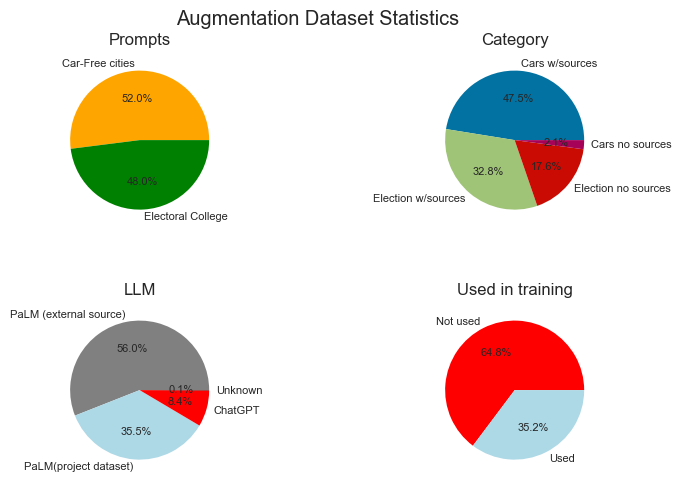

In [82]:
TEXT_SIZE = 8

fig, axes = plt.subplots(2, 2)
fig.tight_layout(pad=3.0)
fig.suptitle("Augmentation Dataset Statistics")

axes[0, 0].pie(full_df.prompt_id.value_counts(), 
        labels=["Car-Free cities", "Electoral College"], 
        textprops={'fontsize': TEXT_SIZE},
        colors=["orange", "green"],
        autopct=f'%1.1f%%')
axes[0, 0].set_title("Prompts")

axes[0, 1].pie(full_df.cluster.value_counts(), 
        labels=cluster_mapping.values(), 
        textprops={'fontsize': TEXT_SIZE},
        autopct=f'%1.1f%%')
axes[0, 1].set_title("Category")

axes[1, 0].pie(full_df.source.value_counts(), 
        labels=["PaLM (external source)", "PaLM(project dataset)", "ChatGPT", "Unknown"], 
        textprops={'fontsize': TEXT_SIZE},
        colors=["gray", "lightblue", "red", "black"],
        autopct=f'%1.1f%%')
axes[1, 0].set_title("LLM")

axes[1, 1].pie(full_df.gold.value_counts(), 
        labels=["Not used", "Used"], 
        textprops={'fontsize': TEXT_SIZE},
        colors=["red", "lightblue"],
        autopct=f'%1.1f%%')
axes[1, 1].set_title("Used in training")


save_plot("augmentation_stats.png")
plt.show()

In [83]:
csv_output(full_df, "augmentation.csv")

File saved successfully as ..\output\augmentation.csv


In [84]:
print(f"Notebook executed in {int((time()-start)// 60)} minutes and {(time()-start) % 60:.1f} seconds")

Notebook executed in 52 minutes and 33.8 seconds
